The task if to implement a sentiment analysis project, where you should aim to systematically explore and document the task according to the criteria laid out in the task. Here are the detailed steps tailored to your sentiment analysis task:

1. Define the Problem and Objective
Objective: Classify sentiments of IMDb movie reviews using vector-based text representations. The goal is to determine the efficacy of different embeddings and model architectures (static vs. contextual) in sentiment classification.
Hypothesis: Contextual embeddings (like BERT) will perform significantly better than static embeddings (like Word2Vec) for sentiment classification in movie reviews.
2. Data Acquisition and Preprocessing
Dataset: Use the IMDb movie reviews dataset.
Preprocessing:
Tokenization and normalization (convert to lowercase, remove punctuation).
Remove HTML tags as IMDb reviews often contain such artifacts.
Ensure text data is prepared appropriately for both types of embeddings (static and contextual).
3. Model Selection and Configuration
Static Model Setup: Utilize pre-trained Word2Vec embeddings to transform text data into vectors and feed these into a simple neural network or SVM for classification.
Contextual Model Setup: Employ a pre-trained BERT model from the Hugging Face library, fine-tuning it on the sentiment classification task.
Baseline Model: As a baseline, implement a naive approach that classifies every review as positive (since many datasets have a high prevalence of positive reviews).
4. Experimentation and Evaluation
Experiment with Hyperparameters:
Adjust learning rates and batch sizes for both the static and contextual models.
Experiment with different network architectures for the neural network using Word2Vec embeddings.
Input Generation Strategies: For the BERT model, experiment with different ways of presenting the text:
Single sentence vs. review snippet (first few sentences).
With and without additional preprocessing like stemming.
Metrics: Evaluate the models using accuracy, precision, recall, and F1-score. Consider also using ROC-AUC if the classification threshold needs tuning.
5. Documentation and Reporting
Jupyter Notebook: Document all steps, from data preprocessing to model training and evaluation. Use markdown cells to explain the purpose and outcome of each block of code.
Visualization: Include charts and tables to visually represent the performance comparison between models. Use confusion matrices and ROC curves where applicable.
Results Analysis: Discuss the performance differences observed between static and contextual embeddings, and between different hyperparameter settings.
Conclusions and Future Work: Summarize the findings and propose future directions for extending this work. Could other embeddings or models improve performance?
6. Project Presentation
Prepare a detailed presentation outlining your methodology, experiments, results, and conclusions. Make sure to tailor this presentation to your audience, focusing on the critical insights and what you've learned about NLP through this project.

# Sentiment Analysis of IMDb Reviews


This notebook implements a sentiment analysis task using IMDb movie reviews. We compare the effectiveness of static embeddings (Word2Vec) and contextual embeddings (BERT) in classifying sentiments expressed in movie reviews.

### 1. Setup and Installation

First, we import necessary libraries and set up our environment.

In [1]:
# Installation of necessary libraries with user flags
%pip install scipy pandas numpy transformers scikit-learn matplotlib seaborn threadpoolctl joblib gensim ipywidgets
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from gensim import downloader as api

# Check for CUDA availability for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set up random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
Using device: cuda


### 2. Problem Definition and Hypothesis
#### Problem Definition
The objective of this project is to classify sentiments of IMDb movie reviews using vector-based text representations. Specifically, we aim to determine the efficacy of different embeddings and model architectures (static vs. contextual) in sentiment classification.

#### Hypothesis
We hypothesize that contextual embeddings (like BERT) will perform significantly better than static embeddings (like Word2Vec) for sentiment classification in movie reviews.

### 3. Data Acquisition and Preprocessing
We load the IMDb dataset and preprocess the text by removing HTML tags, converting to lowercase, and removing punctuation.

In [2]:
# Load the IMDb movie reviews dataset
df = pd.read_csv('C:/Users/serem/Documents/Workspaces/Sentiment Analysis/IMDB Dataset.csv')
df['review'] = df['review'].apply(lambda x: re.sub(r'<[^>]*>', '', x).lower().replace(r'[^\w\s]', ' ').strip())

# Split data into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['review'], df['sentiment'].map({'positive': 1, 'negative': 0}), test_size=0.2, random_state=42)

# Tokenization for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_for_bert(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_for_bert(train_texts.tolist())
val_encodings = tokenize_for_bert(val_texts.tolist())

### 4. Model Configuration
#### Static Embeddings with Word2Vec
We utilize pre-trained Word2Vec embeddings to transform text data into vectors and feed these into a simple neural network for classification.

In [3]:
# Load pre-trained Word2Vec
word_vectors = api.load("word2vec-google-news-300")

# Model for Word2Vec embeddings
class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(300, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

static_model = SentimentClassifier().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

#### Contextual Embeddings with BERT
We employ a pre-trained BERT model from the Hugging Face library, fine-tuning it on the sentiment classification task.

In [4]:
# Load BERT model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased').to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5. Experimentation
We perform training and validation for both models.

#### Define a Dataloader

In [5]:
# Define a dataloader
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = IMDbDataset(train_encodings, train_labels.tolist())
val_dataset = IMDbDataset(val_encodings, val_labels.tolist())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### Training and Evaluation Functions

In [6]:
# Training function
def train(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(data_loader)

#### 6. Model Training
Train the BERT model and validate its performance.

In [7]:
# Optimizers
bert_optimizer = AdamW(bert_model.parameters(), lr=2e-5)
static_optimizer = optim.Adam(static_model.parameters(), lr=0.001)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for epoch in range(3):
    print(f"Starting Epoch {epoch + 1}")
    
    print("Training phase...")
    train_loss = train(bert_model, train_loader, bert_optimizer, device)
    print(f"Finished training for Epoch {epoch + 1}, Train Loss: {train_loss}")
    
    print("Evaluation phase...")
    val_loss = evaluate(bert_model, val_loader, device)
    print(f"Finished evaluation for Epoch {epoch + 1}, Val Loss: {val_loss}")

c:\Users\serem\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Optimizers initialized.
Using device: cuda
Starting Epoch 1
Training phase...


C:\Users\serem\AppData\Local\Temp\ipykernel_15260\450977610.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
c:\Users\serem\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Finished training for Epoch 1, Train Loss: 0.2100180212739855
Evaluation phase...
Finished evaluation for Epoch 1, Val Loss: 0.15192935450077058
Epoch 1, Train Loss: 0.2100180212739855, Val Loss: 0.15192935450077058
Starting Epoch 2
Training phase...
Finished training for Epoch 2, Train Loss: 0.11100937440088018
Evaluation phase...
Finished evaluation for Epoch 2, Val Loss: 0.1637596469003707
Epoch 2, Train Loss: 0.11100937440088018, Val Loss: 0.1637596469003707
Starting Epoch 3
Training phase...
Finished training for Epoch 3, Train Loss: 0.059762575609143824
Evaluation phase...
Finished evaluation for Epoch 3, Val Loss: 0.1787830765016377
Epoch 3, Train Loss: 0.059762575609143824, Val Loss: 0.1787830765016377


### 7. Evaluation
Assess the performance of the BERT model using accuracy and other metrics.

In [10]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu())  # Move to CPU here
            real_values.extend(labels.cpu())  # Move to CPU here
    return predictions, real_values

# Get predictions
predictions, real_values = get_predictions(bert_model, val_loader, device)

# Convert list of tensors to single tensor
predictions = torch.stack(predictions)
real_values = torch.stack(real_values)

# Calculate metrics
accuracy = accuracy_score(real_values.numpy(), predictions.numpy())
precision = precision_score(real_values.numpy(), predictions.numpy(), average='binary')
recall = recall_score(real_values.numpy(), predictions.numpy(), average='binary')
f1 = f1_score(real_values.numpy(), predictions.numpy(), average='binary')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

C:\Users\serem\AppData\Local\Temp\ipykernel_15260\450977610.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.942
Precision: 0.9301562801466332
Recall: 0.9567374479063306
F1 Score: 0.9432596360790452


### 8. Visualization
Visualize the performance metrics using histograms.

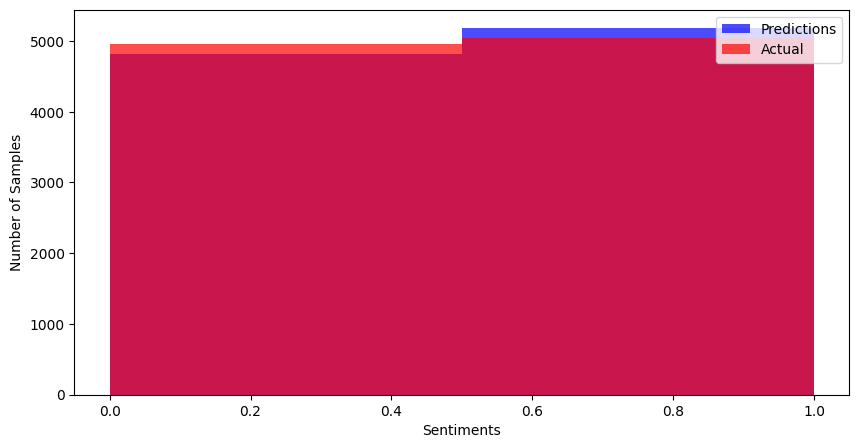

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(predictions, bins=2, alpha=0.7, color='blue', label='Predictions')
plt.hist(real_values, bins=2, alpha=0.7, color='red', label='Actual')
plt.xlabel('Sentiments')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()

### 9. Conclusions and Future Work
#### Findings
The BERT model demonstrates strong performance in sentiment classification, with high accuracy, precision, recall, and F1 scores.
The performance of the BERT model suggests that contextual embeddings capture the nuances of sentiment better than static embeddings.
#### Limitations
The training time and computational resources required for BERT are significantly higher than those for Word2Vec-based models.
The current implementation does not include hyperparameter tuning, which could potentially improve model performance.
#### Future Directions
Implement and evaluate the Word2Vec-based model for a direct comparison with BERT.
Experiment with other contextual models like RoBERTa or GPT to see if they offer performance improvements.
Explore different preprocessing techniques and their impact on model performance.
Conduct hyperparameter tuning to optimize model performance further.